In [1]:
import dataclasses
import jax
from jax import random
from jax import numpy as jnp
import mediapy
from PIL import Image

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from waymax import agents
from waymax import config as _config
from waymax import dynamics
from waymax import dataloader
from waymax import datatypes
from waymax import env as _env

import sys
sys.path.append('../')
sys.path.append('./')

from model.state_preprocessing import extract_heading
from utils.viz import plot_observation_with_mask, plot_observation_with_goal, plot_observation_with_heading
from obs_mask.mask import DistanceObsMask, ConicObsMask, SpeedConicObsMask

CURRENT_TIME_INDEX = 10
N_SIMULATION_STEPS = 80
N_ROLLOUTS = 32

2024-02-16 16:09:07.760002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 16:09:07.760055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 16:09:07.762245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2024-02-16 16:09:08.884152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
config = {
    'anneal_lr': False,
    'bins': 128,
    'discrete': False,
    'key': 42,
    'lr': 3e-4,
    "max_grad_norm": 0.5,
    'max_num_obj': 8,
    'max_num_rg_points': 20000,
    'num_envs': 4,
    'num_envs_eval': 4,
    "num_epochs": 1,
    'num_steps': 80,
    "n_train_per_epoch": 1000,
    'roadgraph_top_k': 500,
    'shuffle_seed': 123,
    'shuffle_buffer_size': 1_000,
    'total_timesteps': 100,
    'training_path': '/data/draco/shared/WOD_1_1_0/tf_example/training/training_tfexample.tfrecord@1000',
    'validation_path': '/data/draco/shared/WOD_1_1_0/tf_example/validation/validation_tfexample.tfrecord@150',
    'testing_path': '/data/draco/shared/WOD_1_1_0/tf_example/testing/testing_tfexample.tfrecord@150'
    }

In [4]:
WOD_1_1_0_TRAINING = _config.DatasetConfig(
    path=config['training_path'],
    max_num_rg_points=20000,
    data_format=_config.DataFormat.TFRECORD,
)

WOD_1_1_0_VALIDATION = _config.DatasetConfig(
    path=config['validation_path'],
    max_num_rg_points=20000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=config['max_num_obj'],
    # batch_dims=(config['num_envs_eval'],)
    batch_dims=(1,)
)

WOD_1_1_0_TESTING = _config.DatasetConfig(
    path=config['testing_path'],
    max_num_rg_points=20000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=config['max_num_obj'],
    # batch_dims=(config['num_envs_eval'],)
)

In [5]:
data_iter = dataloader.simulator_state_generator(config=WOD_1_1_0_VALIDATION)
id = 0

In [8]:
scenario = next(data_iter)
id += 1

print('Scenario idx:', id)
print('Has SDC:', jnp.any(scenario.object_metadata.is_sdc))

_, sdc_idx = jax.lax.top_k(scenario.object_metadata.is_sdc, k=1)
sdc_vel_xy = jnp.take_along_axis(scenario.log_trajectory.vel_xy, sdc_idx[..., None, None], axis=0)
sdc_mean_speed = jax.vmap(lambda x: jnp.sqrt(x[0]**2 + x[1]**2))(sdc_vel_xy[0]).mean()

print('SDC mean speed:', sdc_mean_speed)

Scenario idx: 3
Has SDC: False
SDC mean speed: 3.91611


In [9]:
env_config = _config.EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=_config.ObjectType.VALID,
    max_num_objects=config['max_num_obj']
)

dynamics_model = dynamics.InvertibleBicycleModel()
env = _env.MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=env_config
)

agent = agents.create_constant_speed_actor(
    dynamics_model=dynamics_model,
    # Controlled objects are those valid at t=0.
    is_controlled_func=lambda state: state.log_trajectory.valid[..., CURRENT_TIME_INDEX]
)

## Add limiting observability mask

### Constant mask

In [9]:
key = random.PRNGKey(0)
N = 80

In [10]:
jit_step = jax.jit(env.step)
jit_observe = jax.jit(env.observe)
jit_select_action = jax.jit(agent.select_action)

initial_state = state = env.reset(scenario)
# Controlled objects are those valid at t=0.
is_controlled = scenario.log_trajectory.valid[..., CURRENT_TIME_INDEX]

radius = 20
# Run the sim agent for N steps.
for _ in range(N):
    key, actor_key = random.split(key, 2)
    current_obs = jit_observe(state)
    # actor_output = jit_select_action({}, state, None, actor_key) # Actor action
    next_state = datatypes.update_state_by_log(state, num_steps=1) # Expert action (log traj)
    state = next_state

In [11]:
roadgraph_top_k = 2000
radius = 50
angle = jnp.pi / 4

obs_mask = DistanceObsMask(radius=radius)

plot_mask_fun = lambda ax : obs_mask.plot_mask_fun(ax, center=(0,0))
mask_fun = lambda x, y : obs_mask.mask_fun(x, y)

N = 1

imgs = []

initial_state = current_state = env.reset(scenario)
for _ in range(N):

  # Simulator state
  current_state = datatypes.update_state_by_log(current_state, num_steps=1)
  # Observation
  sdc_obs = datatypes.sdc_observation_from_state(current_state,
                                                 roadgraph_top_k=roadgraph_top_k)

  # Limiting the observation of the SDC to the objects closer than the radius

  visible_obj = mask_fun(sdc_obs.trajectory.x,
                          sdc_obs.trajectory.y) 

  trajectory_limited = dataclasses.replace(sdc_obs.trajectory,
                                            valid=visible_obj)

  sdc_obs_limited = dataclasses.replace(sdc_obs,
                                        trajectory=trajectory_limited)

  img = plot_observation_with_mask(sdc_obs_limited,
                                   obj_idx=0,
                                   mask_function=plot_mask_fun)
  imgs.append(img)

ValueError: Expecting shape () for obs, got (1,)

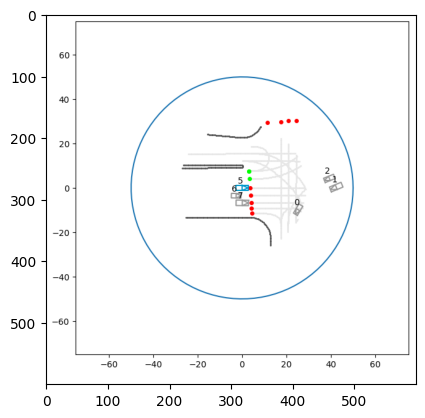

In [38]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
mediapy.show_video(imgs, fps=10)

In [407]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

# Save the frames as a GIF
frames[0].save("../animation/full_obs.gif", save_all=True, append_images=frames[1:], duration=200, loop=0)

### Mask as a function of the speed

In [14]:
from obs_mask.mask import SpeedConicObsMask

ModuleNotFoundError: No module named 'dataclass'

IndexError: index is out of bounds for axis 0 with size 0

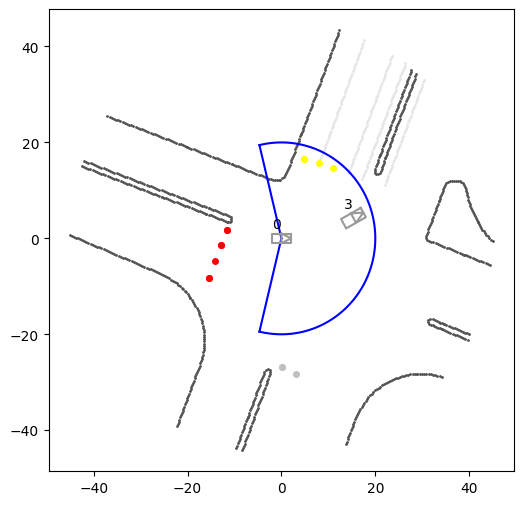

In [13]:
roadgraph_top_k = 2000

N = 80

imgs = []

initial_state = current_state = env.reset(scenario)
for _ in range(N):

  # Simulator state
  current_state = datatypes.update_state_by_log(current_state, num_steps=1)
  # Observation
  sdc_obs = datatypes.sdc_observation_from_state(current_state,
                                                 roadgraph_top_k=roadgraph_top_k)

  # Limiting the observation of the SDC to the objects closer than the radius

  _, sdc_idx = jax.lax.top_k(current_state.object_metadata.is_sdc, k=1)
  sdc_v = jnp.take_along_axis(sdc_obs.trajectory.speed, sdc_idx[..., None, None], axis=-2)

  obs_mask = SpeedConicObsMask(radius=20,
                           angle_min=jnp.pi/8,
                           v_max=15,
                           sdc_v=sdc_v.squeeze()[None, ...])
  
  plot_mask_fun = lambda ax : obs_mask.plot_mask_fun(ax, center=(0,0))
  mask_fun = lambda x, y : obs_mask.mask_fun(x, y)
  
  visible_obj = mask_fun(sdc_obs.trajectory.x[None, ...],
                          sdc_obs.trajectory.y[None, ...]) 

  trajectory_limited = dataclasses.replace(sdc_obs.trajectory,
                                            valid=visible_obj[0, ...])

  sdc_obs_limited = dataclasses.replace(sdc_obs,
                                        trajectory=trajectory_limited)

  img = plot_observation_with_mask(jax.tree_map(lambda x : x[0], sdc_obs_limited),
                                   obj_idx=0,
                                   mask_function=plot_mask_fun)
  imgs.append(img)

In [ ]:
mediapy.show_video(imgs, fps=10)

In [12]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

# Save the frames as a GIF
frames[0].save(f"../animation/limited_FoV/{obs_mask.__class__.__name__}/ex_{id}.gif", save_all=True, append_images=frames[1:], duration=200, loop=0)

FileNotFoundError: [Errno 2] No such file or directory: '../animation/limited_FoV/SpeedConicObsMask/ex_1.gif'

## With a proxy goal 
### Last position of the SDC in the referential of the current position of the SDC

In [13]:
import sys
sys.path.append('../')
sys.path.append('../model')
from model.state_preprocessing import ExtractXYGoal

In [35]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
import jax
import jax.numpy as jnp
from typing import Any, Dict

from model.config import UNVALID_MASK_VALUE
from waymax import datatypes

from utils.observation import last_sdc_observation_for_current_sdc_from_state

class Extractor(ABC):

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        pass
        
    @abstractmethod
    def init_x(self):
        pass

@dataclass
class ExtractXY(Extractor):
    config: Dict

    def __call__(self, state):
        obs = datatypes.sdc_observation_from_state(state,
                                                   roadgraph_top_k=self.config['roadgraph_top_k'])
        traj = obs.trajectory.xy
        valid = obs.trajectory.valid[..., None]
        masked_traj = jnp.where(valid, traj, UNVALID_MASK_VALUE * jnp.ones_like(traj))

        return masked_traj
    
    def init_x(self,):
        return  (jnp.zeros((1, self.config["num_envs"], self.config['max_num_obj'], 2)),
                 jnp.zeros((1, self.config["num_envs"]), dtype=bool),
                 )
    
@dataclass
class ExtractXYGoal(Extractor):
    config: Dict

    def __call__(self, state): 
        
        # Last obs of the log in the current SDC pos referential
        last_sdc_pos = last_sdc_observation_for_current_sdc_from_state(state)

        # Get the last log pos of the SDC
        _, sdc_idx = jax.lax.top_k(state.object_metadata.is_sdc, k=1)
        sdc_xy = jnp.take_along_axis(last_sdc_pos.trajectory.xy[..., 0, :], sdc_idx[..., None, None], axis=-2)
        
        # Mask if no SDC
        mask = jnp.any(state.object_metadata.is_sdc)[..., None]
        # Extract batched proxy goal
        proxy_goal = sdc_xy * mask

        return {"xy": ExtractXY(self.config)(state),
                "proxy_goal": proxy_goal}

    def init_x(self):

        return(
            {'xy': jnp.zeros((1, self.config["num_envs"], self.config['max_num_obj'], 2)),
            'proxy_goal': jnp.zeros((1, self.config["num_envs"], 2))},
            jnp.zeros((1, self.config["num_envs"]), dtype=bool),
        )

In [53]:
roadgraph_top_k = 5000
radius = 50
angle = jnp.pi / 4

N = 80

imgs = []

initial_state = current_state = env.reset(scenario)
for _ in range(N):

  # Simulator state
  current_state = datatypes.update_state_by_log(current_state, num_steps=1)
  # Observation
  sdc_obs = datatypes.sdc_observation_from_state(current_state,
                                                 roadgraph_top_k=roadgraph_top_k)
  
  obs = ExtractXYGoal(config)(current_state)

  img = plot_observation_with_goal(sdc_obs,
                                   obj_idx=0,
                                   goal=obs['proxy_goal'][0, 0])
  imgs.append(img)

In [54]:
mediapy.show_video(imgs, fps=10)

In [57]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

# Save the frames as a GIF
frames[0].save("../animation/goal/ex_1.gif", save_all=True, append_images=frames[1:], duration=200, loop=0)

## With a heading
### The heading is directed in the position of the SDC car at $n$ meters away from the current position

In [49]:
roadgraph_top_k = 5000
radius = 50
angle = jnp.pi / 4

N = 80

imgs = []

initial_state = current_state = env.reset(scenario)

for _ in range(N):

  # Simulator state
  current_state = datatypes.update_state_by_log(current_state, num_steps=1)
  # Observation
  sdc_obs = datatypes.sdc_observation_from_state(current_state,
                                                 roadgraph_top_k=roadgraph_top_k)
  
  sdc_heading = extract_heading(jax.tree_map(lambda x : x[None, ...], current_state), 20)

  img = plot_observation_with_heading(sdc_obs,
                                      obj_idx=0,
                                      heading=sdc_heading.squeeze())
  imgs.append(img)

In [50]:
mediapy.show_video(imgs, fps=10)

In [73]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

# Save the frames as a GIF
frames[0].save(f"../animation/heading/ex_{id}.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)